## Analysis
- Generates `0107_pred_script_2.csv`
- Generates confusion matrix and roc curves for mouse results on tile and wsi level

In [1]:
import re
import seaborn as sns
from scipy.stats import entropy
from tommy_library import *

In [ ]:
import pandas as pd
import numpy as np
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from tqdm import tqdm

import seaborn as sns
from scipy.stats import entropy
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
'Load metadata'
data_fld = '../data'
results_fld = '../results'
sub_fld = os.path.join(data_fld, 'mouse_data')
path = os.path.join(sub_fld, 'wsi_meta.csv')
df_wsi = pd.read_csv(path, index_col=0)
path = os.path.join(sub_fld, 'tile_meta_v2.csv')
df_tile = pd.read_csv(path, index_col=0)

In [3]:
'Load predictions post-inference'
path = os.path.join(sub_fld,'0107_pred_script.csv')
df_tst = pd.read_csv(path, index_col=0)

In [ ]:
'Remove problematic slides'
df_tst = df_tst[df_tst['wsi_name'] != 'Eran Hodis 2020-09-15-026.svs']

In [4]:
df_tst['genotype'].value_counts()

CBTP        5385
CBTP3       3922
CBTPA       3861
CBTA        2313
Multiple    1440
CBT          573
CBT3         115
Name: genotype, dtype: int64

In [5]:
'Process prediction output to legible format'
import re
def parse_str(string, ix):
    n_pt = '([\.0-9\+e\-]+)'
    pattern = '\['+n_pt+'\s+'+n_pt+'\s+'+n_pt+'\s+'+n_pt+'[.\\n\s]+'+n_pt+'[.\\n\s]+'+n_pt
    m = re.match(pattern, string)
    if m is None:
        print('error', string)
        
    CBT_pb, CBTA_pb, CBTP_pb, CBT3_pb, CBTPA_pb, CBTP3_pb = m.groups()
    CBT_pb = float(CBT_pb)
    CBTA_pb = float(CBTA_pb) 
    CBTP_pb = float(CBTP_pb)
    CBT3_pb = float(CBT3_pb)
    CBTPA_pb = float(CBTPA_pb) 
    CBTP3_pb = float(CBTP3_pb)
    all_pbs = [CBT_pb, CBTA_pb, CBTP_pb, CBT3_pb, CBTPA_pb, CBTP3_pb]
    return all_pbs[ix]

CBT_pb = lambda x: parse_str(x, 0)
CBTA_pb = lambda x: parse_str(x, 1)
CBTP_pb = lambda x: parse_str(x, 2)
CBT3_pb = lambda x: parse_str(x, 3)
CBTPA_pb = lambda x: parse_str(x, 4)
CBTP3_pb = lambda x: parse_str(x, 5)

In [6]:
df_tst['CBT'] = df_tst.pred_prob.map(CBT_pb)
df_tst['CBTA'] = df_tst.pred_prob.map(CBTA_pb)
df_tst['CBTP'] = df_tst.pred_prob.map(CBTP_pb)
df_tst['CBT3'] = df_tst.pred_prob.map(CBT3_pb)
df_tst['CBTPA'] = df_tst.pred_prob.map(CBTPA_pb)
df_tst['CBTP3'] = df_tst.pred_prob.map(CBTP3_pb)

In [7]:
'Assing most likely prediction'
classes  = ['CBT', 'CBT3', 'CBTA', 'CBTP', 'CBTP3', 'CBTPA']
preds = np.argmax(df_tst[classes].values, axis=1)
ix2cl = {ix: cl for ix, cl in enumerate(classes)}
df_tst['prediction'] = [ix2cl[p] for p in preds]

In [ ]:
'Removing tiles from WSIs associated with multiple genotypes'
mask_multiple = df_tst.genotype == 'Multiple'
print("Number of tiles with Multiple genotypes: ", df_tst[mask_multiple].shape[0])
df_tst = df_tst[~mask_multiple]

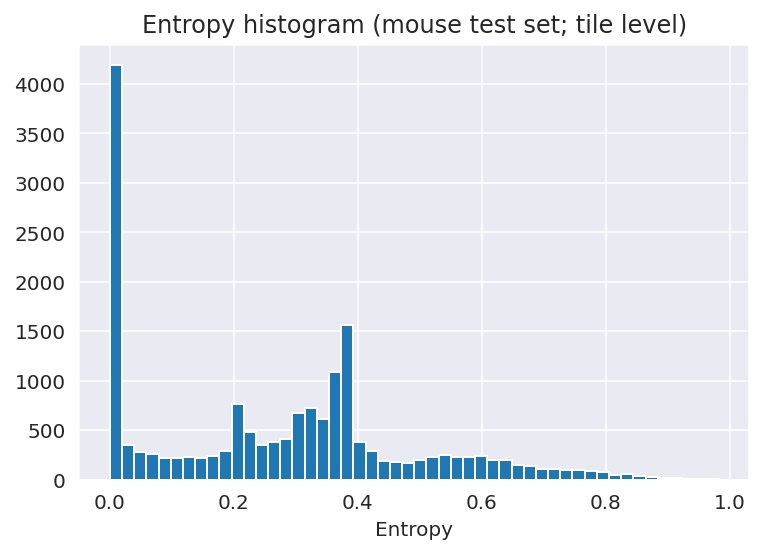

In [8]:
'Compute entropy'
import seaborn as sns
sns.set_style('darkgrid')
plt.title('Entropy histogram (mouse test set; tile level)')
plt.xlabel('Entropy')
df_tst['tile_entropy'] = entropy(df_tst[classes], axis=1, base=6)
df_tst.tile_entropy.hist(bins=50);
plt.savefig('../results/entropy_histogram_mouse_tile.pdf');
plt.close()

In [9]:
'Assign uncertain predictions'
mask = df_tst.tile_entropy > .2  # greater than .2 are uncertain
df_tst.loc[mask, 'prediction'] = 'Uncertain'
(df_tst.prediction == 'Uncertain').sum()

11030

In [10]:
df_tst.to_csv('../results/0107_pred_script_2.csv')

In [11]:
df_tst

,wsi_id,wsi_name,genotype,x_tile_coord,y_tile_coord,file,batch,animal_id,dissected_region,is_CBTP_old,...,is_test,pred_prob,CBT,CBTA,CBTP,CBT3,CBTPA,CBTP3,prediction,tile_entropy
0,Eran Hodis 2020-09-15-012_Multiple,Eran Hodis 2020-09-15-012.svs,Multiple,28,6,Eran Hodis 2020-09-15-012_28_6_Multiple.png,L41,multiple,TMA01,False,...,True,[9.7655630e-01 3.8493329e-04 7.5743992e-06 2.3...,9.765563e-01,3.849333e-04,7.574399e-06,2.305123e-02,3.337556e-11,1.240714e-12,CBT,0.063171
1,Eran Hodis 2020-09-15-012_Multiple,Eran Hodis 2020-09-15-012.svs,Multiple,40,4,Eran Hodis 2020-09-15-012_40_4_Multiple.png,L41,multiple,TMA01,False,...,True,[3.7247296e-06 1.1470235e-01 4.2321177e-12 1.2...,3.724730e-06,1.147023e-01,4.232118e-12,1.269024e-08,8.852940e-01,1.304739e-10,CBTPA,0.198847
2,Eran Hodis 2020-09-15-012_Multiple,Eran Hodis 2020-09-15-012.svs,Multiple,3,13,Eran Hodis 2020-09-15-012_3_13_Multiple.png,L41,multiple,TMA01,False,...,True,[1.8061758e-07 1.6688416e-08 4.0280235e-01 4.1...,1.806176e-07,1.668842e-08,4.028023e-01,4.171636e-07,4.725316e-09,5.971971e-01,Uncertain,0.376245
3,Eran Hodis 2020-09-15-012_Multiple,Eran Hodis 2020-09-15-012.svs,Multiple,44,16,Eran Hodis 2020-09-15-012_44_16_Multiple.png,L41,multiple,TMA01,False,...,True,[2.8712642e-14 2.1835533e-03 6.8458145e-14 3.8...,2.871264e-14,2.183553e-03,6.845815e-14,3.825618e-15,9.978164e-01,1.287590e-09,CBTPA,0.008684
4,Eran Hodis 2020-09-15-012_Multiple,Eran Hodis 2020-09-15-012.svs,Multiple,6,12,Eran Hodis 2020-09-15-012_6_12_Multiple.png,L41,multiple,TMA01,False,...,True,[9.1605351e-08 5.7414979e-09 6.5767425e-01 2.3...,9.160535e-08,5.741498e-09,6.576743e-01,2.378826e-07,1.536402e-09,3.423254e-01,Uncertain,0.358626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23586,EH-15740-006_CBTP,EH-15740-006.svs,CBTP,32,5,EH-15740-006_32_5_CBTP.png,L40,209,XR,False,...,True,[2.5547255e-04 2.4191537e-05 3.3379000e-01 5.9...,2.554725e-04,2.419154e-05,3.337900e-01,5.986192e-04,1.267676e-05,6.653190e-01,Uncertain,0.359599
23587,EH-15740-006_CBTP,EH-15740-006.svs,CBTP,3,4,EH-15740-006_3_4_CBTP.png,L40,209,XR,False,...,True,[6.7490386e-04 1.7933224e-03 6.7616808e-01 2.8...,6.749039e-04,1.793322e-03,6.761681e-01,2.856940e-02,1.208532e-04,2.926735e-01,Uncertain,0.414752
23588,EH-15740-006_CBTP,EH-15740-006.svs,CBTP,33,4,EH-15740-006_33_4_CBTP.png,L40,209,XR,False,...,True,[4.2319815e-03 3.7668021e-03 2.1264513e-01 2.6...,4.231981e-03,3.766802e-03,2.126451e-01,2.644529e-02,3.015958e-04,7.526093e-01,Uncertain,0.382733
23589,EH-15740-006_CBTP,EH-15740-006.svs,CBTP,32,3,EH-15740-006_32_3_CBTP.png,L40,209,XR,False,...,True,[2.0613261e-04 1.9642926e-04 3.6439484e-01 6.5...,2.061326e-04,1.964293e-04,3.643948e-01,6.521632e-03,7.293389e-05,6.286080e-01,Uncertain,0.388799


***
#### Confusion matrix for genotypes

In [11]:
'Remove uncertain predictions from tiles'
mask_1 = df_tst.genotype != 'Multiple'
mask_2 = df_tst.prediction != 'Uncertain'
mask = mask_1 & mask_2
df_tst_tile_flt = df_tst[mask]
print('{:.2f} predictions kept'.format(mask_2.sum() / len(df_tst)))

0.37 predictions kept


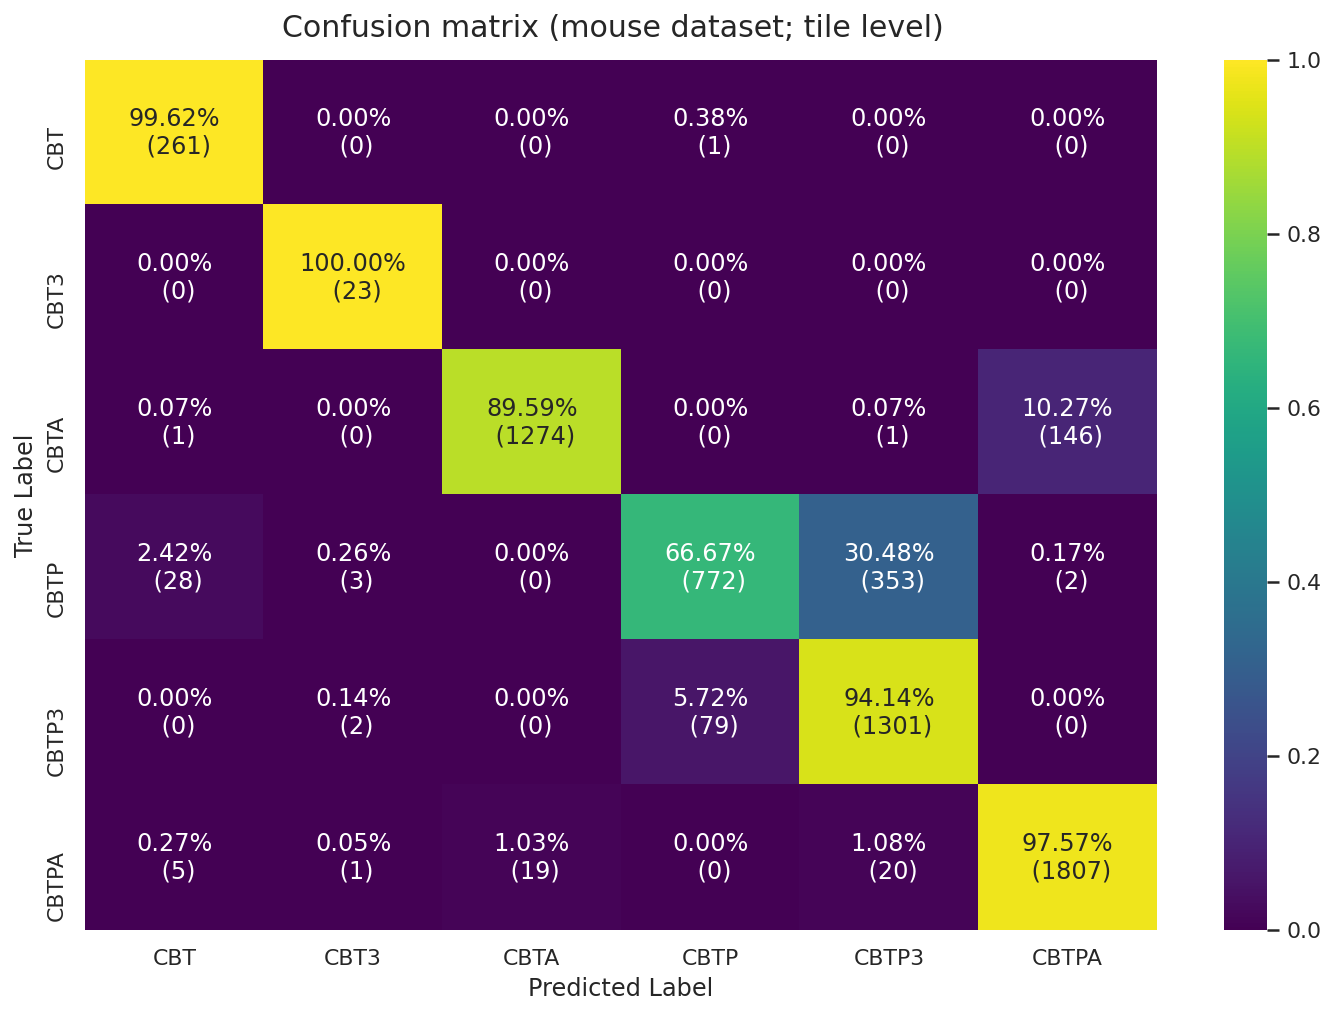

In [12]:
'Super code for confusion matrix'
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_tst_tile_flt['genotype'], df_tst_tile_flt['prediction'], labels=classes)
cma = np.array(cm)
prop = np.zeros(cma.shape)
for i in range(prop.shape[0]):
    total = sum(cma[i])
    for j in range(prop.shape[1]):
        prop[i][j] = cma[i][j]/total
labels = (np.asarray([( "{:.2f}".format(string*100)  +  "%\n", "(" + str(value) + ")" ) for string, value in zip(prop.flatten(), cma.flatten())]))
labels = np.array([" ".join(item) for item in labels.astype(str)])
labels = labels.reshape(6,6)
#labels = labels.reshape(2,2)
df_cm = pd.DataFrame(prop, index=classes, columns=classes)
import seaborn as sns
sns.set(font_scale=1)
plt.figure(figsize = (12,8))
ax = sns.heatmap(df_cm, annot=labels, cmap="viridis", fmt="")
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.figtext(.43,.9, 'Confusion matrix (mouse dataset; tile level)', fontsize=15, ha='center');
plt.savefig('../results/confusion_matrix_tile.pdf')
plt.close()

In [13]:
'Merge tile dataframe with connected component information'
path = os.path.join(sub_fld, 'tile_meta_v2.csv')
df_tile = pd.read_csv(path, index_col=0)
df_tst_tile_flt_2 = df_tst_tile_flt.merge(df_tile[['connected_component']], how='inner', left_index=True, right_index=True)
assert len(df_tst_tile_flt_2) == len(df_tst_tile_flt)

In [14]:
'Get prediction at level of connected components'
g = df_tst_tile_flt_2.groupby(['wsi_id', 'genotype', 'connected_component'])
label_subset = classes  # + ['animal_id', 'batch', 'dissected_region']
df_tst_wsi = g.sum()[label_subset]
preds = np.argmax(df_tst_wsi[classes].values, axis=1)
df_tst_wsi['conn_pred'] = [ix2cl[p] for p in preds]
df_tst_wsi = df_tst_wsi.reset_index()
df_tst_wsi['entropy'] = entropy(df_tst_wsi[classes], axis=1, base=6)
df_tst_wsi.head(3)

,wsi_id,genotype,connected_component,CBT,CBT3,CBTA,CBTP,CBTP3,CBTPA,conn_pred,entropy
0,EH-15740-000_CBTP,CBTP,1,0.000055,0.999550,0.000312,1.898736,0.101346,7.687492e-07,CBTP,0.430473
1,EH-15740-000_CBTP,CBTP,2,1.919705,0.028177,0.041176,0.952942,0.056728,1.271872e-03,CBT,0.463784
2,EH-15740-001_CBTP,CBTP,1,0.089358,0.000691,0.001020,3.805730,0.103194,7.196208e-06,CBTP,0.128520


In [ ]:
'Get prediction at level of WSIs'
gw = df_tst_wsi.groupby(['wsi_id', 'genotype'])
label_subset = classes  # + ['animal_id', 'batch', 'dissected_region']
df_tst_wsi_2 = gw.sum()[label_subset]
preds = np.argmax(df_tst_wsi_2[classes].values, axis=1)
df_tst_wsi_2['wsi_pred'] = [ix2cl[p] for p in preds]
df_tst_wsi_2 = df_tst_wsi_2.reset_index()
df_tst_wsi_2['entropy'] = entropy(df_tst_wsi_2[classes], axis=1, base=6)
df_tst_wsi_2.head(3)

In [ ]:
df_tst_wsi_2.to_csv('../results/0107_pred_wsi.csv')

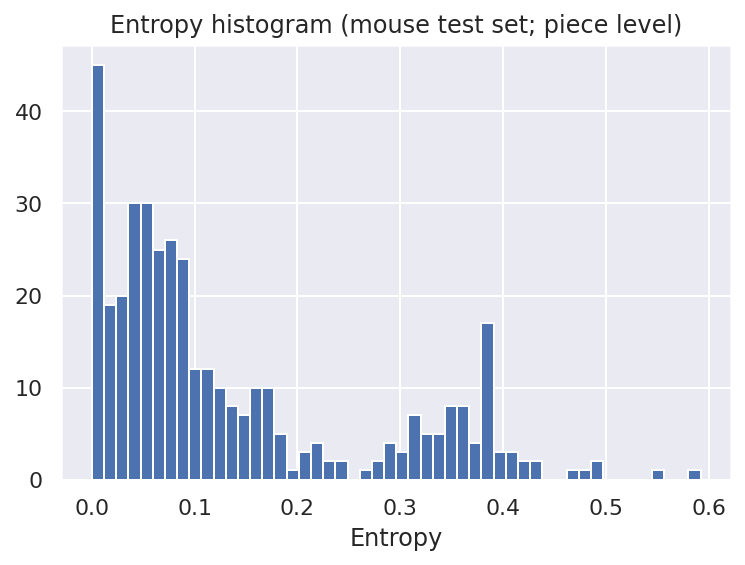

In [15]:
plt.title('Entropy histogram (mouse test set; piece level)')
plt.xlabel('Entropy')
df_tst_wsi.entropy.hist(bins=50);
plt.savefig('../results/entropy_histogram_mouse_wsi.pdf');
plt.close()

In [16]:
'Threshold entropy to label uncertain predictions'
mask = df_tst_wsi.entropy > .2
df_tst_wsi.loc[mask, 'conn_pred'] = 'Uncertain'

In [17]:
'filter dataframe prior to confusion matrix'
mask_1 = df_tst_wsi.genotype != 'Multiple'
mask_2 = df_tst_wsi.conn_pred != 'Uncertain'
mask = mask_1 & mask_2
df_tst_wsi_flt = df_tst_wsi[mask]
print('{:.2f} predictions kept'.format(mask_2.sum() / len(df_tst_wsi)))

0.76 predictions kept


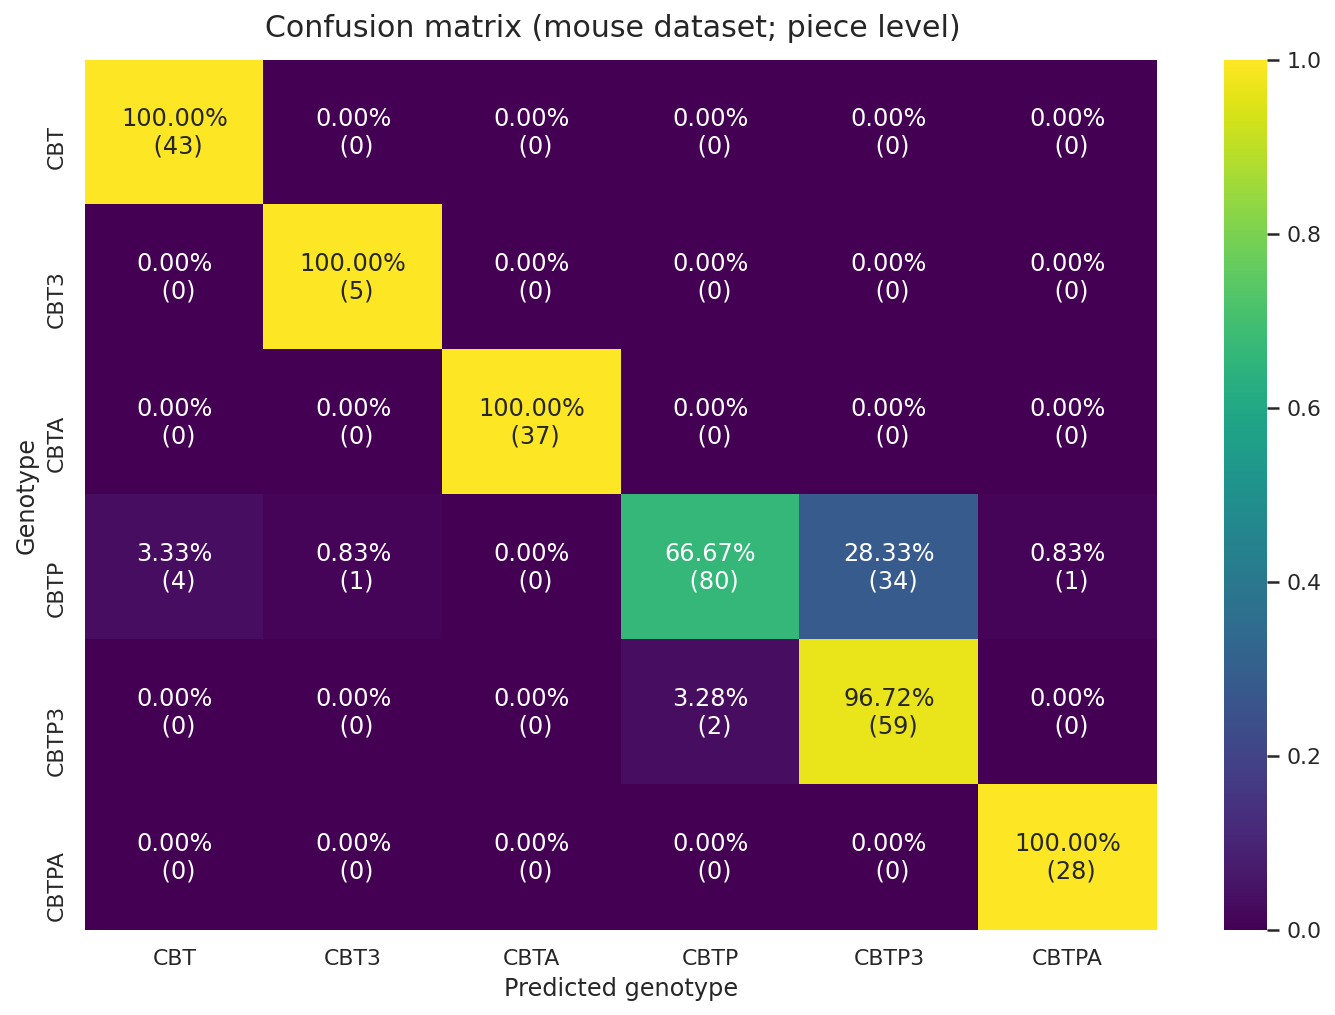

In [18]:
'Super Saurabh code for confusion matrix'
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(df_tst_wsi_flt['genotype'], df_tst_wsi_flt['conn_pred'], labels=classes)
cma = np.array(cm)
prop = np.zeros(cma.shape)
for i in range(prop.shape[0]):
    total = sum(cma[i])
    for j in range(prop.shape[1]):
        prop[i][j] = cma[i][j]/total
labels = (np.asarray([( "{:.2f}".format(string*100)  +  "%\n", "(" + str(value) + ")" ) for string, value in zip(prop.flatten(), cma.flatten())]))
labels = np.array([" ".join(item) for item in labels.astype(str)])
labels = labels.reshape(6,6)
#labels = labels.reshape(2,2)
df_cm = pd.DataFrame(prop, index=classes, columns=classes)
import seaborn as sns
sns.set(font_scale=1)
plt.figure(figsize = (12,8))
ax = sns.heatmap(df_cm, annot=labels, cmap="viridis", fmt="")
ax.set(xlabel='Predicted genotype', ylabel='Genotype')
plt.figtext(.43,.9, 'Confusion matrix (mouse dataset; piece level)', fontsize=15, ha='center');
plt.savefig('../results/confusion_matrix_piece.pdf');
plt.close()

***
### ROC for genotypes

In [19]:
# from scipy.stats import gamma

In [22]:
# 'Helper for ROC mean curve'
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_roc_xy(dataframe):
    """
    """
    global xs
    
    df = dataframe.copy()
    df.columns = ['true', 'pred']
    fpr, tpr, thr = roc_curve(df.true, df.pred)
    return fpr, tpr


In [23]:
df_tst_wsi

,wsi_id,genotype,connected_component,CBT,CBT3,CBTA,CBTP,CBTP3,CBTPA,conn_pred,entropy
0,EH-15740-000_CBTP,CBTP,1,0.000055,0.999550,0.000312,1.898736e+00,0.101346,7.687492e-07,Uncertain,0.430473
1,EH-15740-000_CBTP,CBTP,2,1.919705,0.028177,0.041176,9.529423e-01,0.056728,1.271872e-03,Uncertain,0.463784
2,EH-15740-001_CBTP,CBTP,1,0.089358,0.000691,0.001020,3.805730e+00,0.103194,7.196208e-06,CBTP,0.128520
3,EH-15740-001_CBTP,CBTP,2,0.002691,0.005581,0.023422,5.700498e-03,0.046956,1.915649e+00,CBTPA,0.124710
4,EH-15740-001_CBTP,CBTP,3,1.046326,0.003664,0.008696,3.823316e+00,2.117935,6.265826e-05,Uncertain,0.551693
...,...,...,...,...,...,...,...,...,...,...,...
380,Eran Hodis 2020-09-15-045_CBTA,CBTA,1,0.004005,0.000092,21.904298,6.259381e-06,0.000034,9.156583e-02,CBTA,0.016074
381,Eran Hodis 2020-09-15-045_CBTA,CBTA,2,0.004886,0.000019,62.787763,1.828436e-07,0.000002,2.073297e-01,CBTA,0.012789
382,Eran Hodis 2020-09-15-045_CBTA,CBTA,4,0.008575,0.001303,46.765007,3.354617e-05,0.000072,5.225010e+00,CBTA,0.183082
383,Eran Hodis 2020-09-15-045_CBTA,CBTA,5,0.001252,0.000261,24.932558,1.473061e-05,0.000031,6.588341e-02,CBTA,0.010596


In [24]:
'Normalize probabilities'
total_probs = df_tst_wsi_flt.CBT + df_tst_wsi_flt.CBT3 + df_tst_wsi_flt.CBTA + df_tst_wsi_flt.CBTP + df_tst_wsi_flt.CBTP3 + df_tst_wsi_flt.CBTPA
df_tst_wsi_flt.loc[:, 'CBT'] = df_tst_wsi_flt['CBT'] / total_probs 
df_tst_wsi_flt.loc[:, 'CBT3'] = df_tst_wsi_flt['CBT3'] / total_probs 
df_tst_wsi_flt.loc[:, 'CBTA'] = df_tst_wsi_flt['CBTA'] / total_probs 
df_tst_wsi_flt.loc[:, 'CBTP'] = df_tst_wsi_flt['CBTP'] / total_probs 
df_tst_wsi_flt.loc[:, 'CBTP3'] = df_tst_wsi_flt['CBTP3'] / total_probs 
df_tst_wsi_flt.loc[:, 'CBTPA'] = df_tst_wsi_flt['CBTPA'] / total_probs 
total_probs = df_tst_wsi_flt.CBT + df_tst_wsi_flt.CBT3 + df_tst_wsi_flt.CBTA + df_tst_wsi_flt.CBTP + df_tst_wsi_flt.CBTP3 + df_tst_wsi_flt.CBTPA
assert total_probs.sum() == len(df_tst_wsi_flt)

/home/tbiancal/miniconda3/envs/dev/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [25]:
mask = df_tst_wsi_flt.genotype == 'CBT'
df_tst_wsi_flt.loc[:, 'CBT_gt'] = mask.values
mask = df_tst_wsi_flt.genotype == 'CBT3'
df_tst_wsi_flt.loc[:, 'CBT3_gt'] = mask.values
mask = df_tst_wsi_flt.genotype == 'CBTA'
df_tst_wsi_flt.loc[:, 'CBTA_gt'] = mask.values
mask = df_tst_wsi_flt.genotype == 'CBT3'
df_tst_wsi_flt.loc[:, 'CBT3_gt'] = mask.values
mask = df_tst_wsi_flt.genotype == 'CBTP'
df_tst_wsi_flt.loc[:, 'CBTP_gt'] = mask.values
mask = df_tst_wsi_flt.genotype == 'CBTP3'
df_tst_wsi_flt.loc[:, 'CBTP3_gt'] = mask.values
mask = df_tst_wsi_flt.genotype == 'CBTPA'
df_tst_wsi_flt.loc[:, 'CBTPA_gt'] = mask.values

/home/tbiancal/miniconda3/envs/dev/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/tbiancal/miniconda3/envs/dev/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


- If I need to average them, I can just take CBTP and CBTP3.

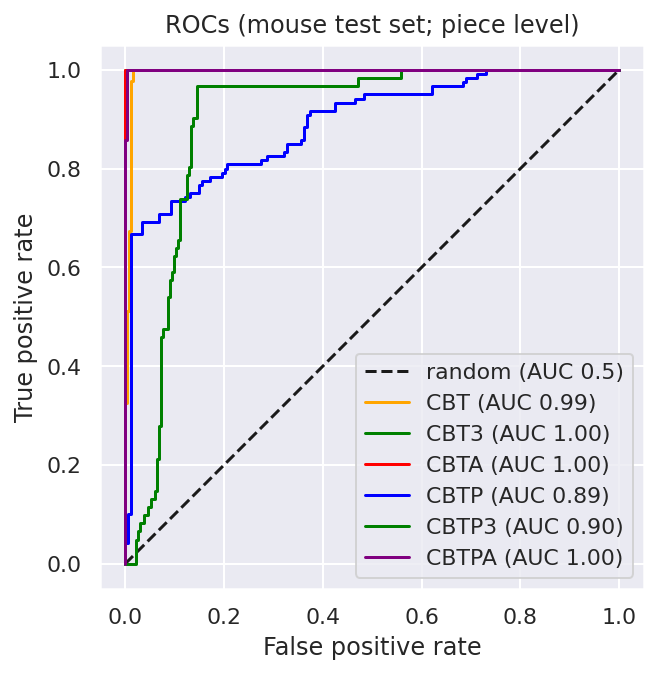

In [26]:
'Compute ROC curves and plot'
roc_CBT_x, roc_CBT_y = get_roc_xy(df_tst_wsi_flt[['CBT_gt', 'CBT']])
auc_CBT = roc_auc_score(df_tst_wsi_flt['CBT_gt'], df_tst_wsi_flt['CBT'])

roc_CBT3_x, roc_CBT3_y = get_roc_xy(df_tst_wsi_flt[['CBT3_gt', 'CBT3']])
auc_CBT3 = roc_auc_score(df_tst_wsi_flt['CBT3_gt'], df_tst_wsi_flt['CBT3'])

roc_CBTA_x, roc_CBTA_y = get_roc_xy(df_tst_wsi_flt[['CBTA_gt', 'CBTA']])
auc_CBTA = roc_auc_score(df_tst_wsi_flt['CBTA_gt'], df_tst_wsi_flt['CBTA'])

roc_CBTP_x, roc_CBTP_y = get_roc_xy(df_tst_wsi_flt[['CBTP_gt', 'CBTP']])
auc_CBTP = roc_auc_score(df_tst_wsi_flt['CBTP_gt'], df_tst_wsi_flt['CBTP'])

roc_CBTP3_x, roc_CBTP3_y = get_roc_xy(df_tst_wsi_flt[['CBTP3_gt', 'CBTP3']])
auc_CBTP3 = roc_auc_score(df_tst_wsi_flt['CBTP3_gt'], df_tst_wsi_flt['CBTP3'])

roc_CBTPA_x, roc_CBTPA_y = get_roc_xy(df_tst_wsi_flt[['CBTPA_gt', 'CBTPA']])
auc_CBTPA = roc_auc_score(df_tst_wsi_flt['CBTPA_gt'], df_tst_wsi_flt['CBTPA'])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot([0, 1], [0, 1], 'k--', label='random (AUC 0.5)')

ax.plot(roc_CBT_x, roc_CBT_y, label='CBT (AUC {:.2f})'.format(auc_CBT), c='orange');
ax.plot(roc_CBT3_x, roc_CBT3_y, label='CBT3 (AUC {:.2f})'.format(auc_CBT3), c='green');
ax.plot(roc_CBTA_x, roc_CBTA_y, label='CBTA (AUC {:.2f})'.format(auc_CBTA), c='red');
ax.plot(roc_CBTP_x, roc_CBTP_y, label='CBTP (AUC {:.2f})'.format(auc_CBTP), c='blue');
ax.plot(roc_CBTP3_x, roc_CBTP3_y, label='CBTP3 (AUC {:.2f})'.format(auc_CBTP3), c='green');
ax.plot(roc_CBTPA_x, roc_CBTPA_y, label='CBTPA (AUC {:.2f})'.format(auc_CBTPA), c='purple');

ax.set_aspect(1)
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend(loc='lower right');
ax.set_title('ROCs (mouse test set; piece level)')

plt.savefig('../results/roc_mouse_piece_level.pdf');

In [27]:
mask = df_tst_tile_flt.genotype == 'CBT'
df_tst_tile_flt.loc[:, 'CBT_gt'] = mask.values
mask = df_tst_tile_flt.genotype == 'CBT3'
df_tst_tile_flt.loc[:, 'CBT3_gt'] = mask.values
mask = df_tst_tile_flt.genotype == 'CBTA'
df_tst_tile_flt.loc[:, 'CBTA_gt'] = mask.values
mask = df_tst_tile_flt.genotype == 'CBT3'
df_tst_tile_flt.loc[:, 'CBT3_gt'] = mask.values
mask = df_tst_tile_flt.genotype == 'CBTP'
df_tst_tile_flt.loc[:, 'CBTP_gt'] = mask.values
mask = df_tst_tile_flt.genotype == 'CBTP3'
df_tst_tile_flt.loc[:, 'CBTP3_gt'] = mask.values
mask = df_tst_tile_flt.genotype == 'CBTPA'
df_tst_tile_flt.loc[:, 'CBTPA_gt'] = mask.values

/home/tbiancal/miniconda3/envs/dev/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/tbiancal/miniconda3/envs/dev/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


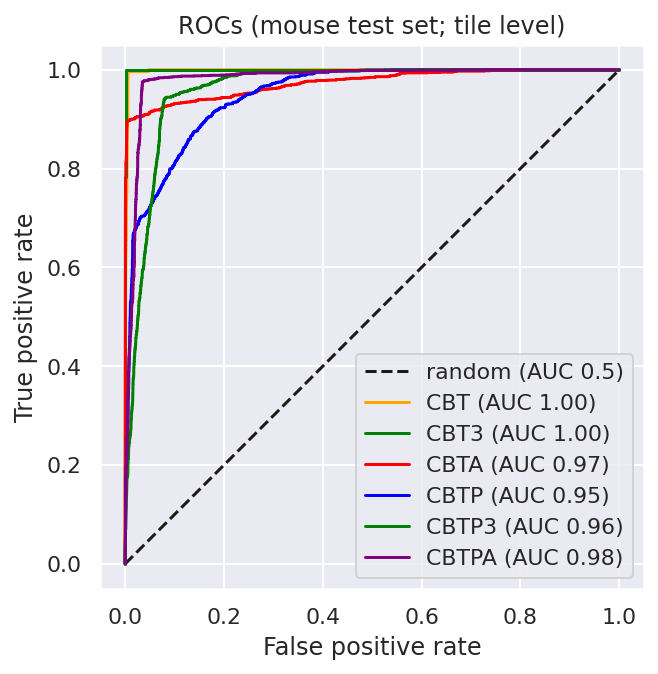

In [28]:
'Compute ROC curves and plot'
roc_CBT_x, roc_CBT_y = get_roc_xy(df_tst_tile_flt[['CBT_gt', 'CBT']])
auc_CBT = roc_auc_score(df_tst_tile_flt['CBT_gt'], df_tst_tile_flt['CBT'])

roc_CBT3_x, roc_CBT3_y = get_roc_xy(df_tst_tile_flt[['CBT3_gt', 'CBT3']])
auc_CBT3 = roc_auc_score(df_tst_tile_flt['CBT3_gt'], df_tst_tile_flt['CBT3'])

roc_CBTA_x, roc_CBTA_y = get_roc_xy(df_tst_tile_flt[['CBTA_gt', 'CBTA']])
auc_CBTA = roc_auc_score(df_tst_tile_flt['CBTA_gt'], df_tst_tile_flt['CBTA'])

roc_CBTP_x, roc_CBTP_y = get_roc_xy(df_tst_tile_flt[['CBTP_gt', 'CBTP']])
auc_CBTP = roc_auc_score(df_tst_tile_flt['CBTP_gt'], df_tst_tile_flt['CBTP'])

roc_CBTP3_x, roc_CBTP3_y = get_roc_xy(df_tst_tile_flt[['CBTP3_gt', 'CBTP3']])
auc_CBTP3 = roc_auc_score(df_tst_tile_flt['CBTP3_gt'], df_tst_tile_flt['CBTP3'])

roc_CBTPA_x, roc_CBTPA_y = get_roc_xy(df_tst_tile_flt[['CBTPA_gt', 'CBTPA']])
auc_CBTPA = roc_auc_score(df_tst_tile_flt['CBTPA_gt'], df_tst_tile_flt['CBTPA'])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot([0, 1], [0, 1], 'k--', label='random (AUC 0.5)')

ax.plot(roc_CBT_x, roc_CBT_y, label='CBT (AUC {:.2f})'.format(auc_CBT), c='orange');
ax.plot(roc_CBT3_x, roc_CBT3_y, label='CBT3 (AUC {:.2f})'.format(auc_CBT3), c='green');
ax.plot(roc_CBTA_x, roc_CBTA_y, label='CBTA (AUC {:.2f})'.format(auc_CBTA), c='red');
ax.plot(roc_CBTP_x, roc_CBTP_y, label='CBTP (AUC {:.2f})'.format(auc_CBTP), c='blue');
ax.plot(roc_CBTP3_x, roc_CBTP3_y, label='CBTP3 (AUC {:.2f})'.format(auc_CBTP3), c='green');
ax.plot(roc_CBTPA_x, roc_CBTPA_y, label='CBTPA (AUC {:.2f})'.format(auc_CBTPA), c='purple');

ax.set_aspect(1)
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.legend(loc='lower right');
ax.set_title('ROCs (mouse test set; tile level)')

plt.savefig('../results/roc_mouse_tile_level.pdf');

***
#### ROC for single KO predictons (not insert in paper)

In [31]:
'Prepare labels for ROCs'
# ground truth
df_tst_wsi_flt.loc[:, 'APC'] = df_tst_wsi_flt.genotype.isin(['CBTA', 'CBTPA'])
df_tst_wsi_flt.loc[:, 'PTEN'] = df_tst_wsi_flt.genotype.isin(['CBTPA', 'CBTP3', 'CBTP'])
df_tst_wsi_flt.loc[:, 'P53'] = df_tst_wsi_flt.genotype.isin(['CBT3', 'CBTP3'])

# predicted probabilities of KO
df_tst_wsi_flt.loc[:, 'P53_prob'] = (df_tst_wsi_flt.CBT3 + df_tst_wsi_flt.CBTP3)
df_tst_wsi_flt.loc[:, 'PTEN_prob'] = (df_tst_wsi_flt.CBTPA + df_tst_wsi_flt.CBTP3 + df_tst_wsi_flt.CBTP)  
df_tst_wsi_flt.loc[:, 'APC_prob'] = (df_tst_wsi_flt.CBTPA + df_tst_wsi_flt.CBTA)  

/home/tbiancal/miniconda3/envs/dev/lib/python3.7/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/tbiancal/miniconda3/envs/dev/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
